In [ ]:
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import numpy as np
from matplotlib import cm, pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [2]:
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']
import pandas as pd
import os
init_dir_path = str(os.getcwd())  # find current working directory
stock_paths=[init_dir_path+'/stock_data/'+x+'_prices.csv' for x in stocks]

In [23]:
features=['Return','Volatility','HighR','LowR',"Volume"]
data_full=[]
for sp,sn in zip(stock_paths,stocks):
    s=pd.read_csv(sp)
    #s=s.drop(['High','Low','Volume'],axis=1)
    s['Return']=100*(s['Close']-s['Open'])/s['Open']
    s['HighR']=100*(s['High']-s['Open'])/s['Open']
    s['LowR']=100*(s['Low']-s['Open'])/s['Open']
    s['Volatility']=s['Return'].rolling(window=3).std()
    s['Date']=pd.to_datetime(s['Date'])
    s=s.iloc[3:]
    s=s.reset_index(drop=True)
    #s[features]=StandardScaler().fit_transform(s[features])
    s['Ticker']=sn
    s["Volume"] = np.log(1+s["Volume"])
    data_full.append(s)

In [12]:
data_with_date=[x[features+["Date"]] for x in data_full]
data = [x[features] for x in data_full]

In [33]:
from filterpy.kalman import KalmanFilter
import optuna
# Kalman smoother function
def kalman_smooth(series, q):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([[series.iloc[0]], [0.]])
    kf.F = np.array([[1., 1.], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = np.var(series) * 0.5
    kf.Q = np.array([[q, 0.], [0., q]])

    result = []
    for val in series:
        kf.predict()
        kf.update(val)
        result.append(kf.x[0, 0])
    return result

In [34]:
def objective_with_args(df):
    def inner(trial):
        df_local = df.copy()
        smooth_errors = []

        for feature in features:
            q = trial.suggest_float(f"q_{feature}", 1e-6, 1e-3, log=True)
            series = df_local[feature]
            if feature == "Volume":
                series = np.log(series + 1e-6)  # avoid log(0)
            smooth = kalman_smooth(series, q)
            df_local[f"Smooth_{feature}"] = smooth

            # Add a proxy error metric: how far is the smoothed series from the original?
            mse = np.mean((series.iloc[1:] - np.array(smooth[1:]))**2)
            smooth_errors.append(mse)

        return -np.mean(smooth_errors)  # Negative so Optuna maximizes smoothness quality

    return inner

In [36]:
for s_ind in range(len(stocks)):
    print(f"Tuning Kalman smoothing for stock: {stocks[s_ind]}")
    df_stock = data[s_ind]

    study = optuna.create_study(direction="maximize")
    study.optimize(objective_with_args(df_stock), n_trials=50)

    best_qs = study.best_params

    # Apply best Qs to full data and store smoothed features
    for feature in features:
        series = data_with_date[s_ind][feature]
        data_with_date[s_ind][f"Smooth_{feature}"] = kalman_smooth(series, best_qs[f"q_{feature}"])


[I 2025-04-14 01:05:39,208] A new study created in memory with name: no-name-27b27d3a-836b-4190-b81e-972bf50de029


Tuning Kalman smoothing for stock: aapl


[I 2025-04-14 01:05:40,060] Trial 0 finished with value: -1.1214223419380995 and parameters: {'q_Return': 0.00012355271704791635, 'q_Volatility': 0.00013064907240356076, 'q_HighR': 7.715147541145076e-05, 'q_LowR': 4.980616221411837e-06, 'q_Volume': 0.0005657230939704917}. Best is trial 0 with value: -1.1214223419380995.
[I 2025-04-14 01:05:40,909] Trial 1 finished with value: -1.1482530582982793 and parameters: {'q_Return': 1.3477937972557536e-06, 'q_Volatility': 0.0002860908243887927, 'q_HighR': 4.395126592395748e-06, 'q_LowR': 0.00044921613387414544, 'q_Volume': 2.383282328795157e-05}. Best is trial 0 with value: -1.1214223419380995.
[I 2025-04-14 01:05:41,759] Trial 2 finished with value: -1.1693406431553115 and parameters: {'q_Return': 1.1584706304870223e-05, 'q_Volatility': 8.002687025606095e-05, 'q_HighR': 5.198852507619146e-06, 'q_LowR': 3.6747290425450344e-05, 'q_Volume': 0.0003881920025720831}. Best is trial 0 with value: -1.1214223419380995.
[I 2025-04-14 01:05:42,600] Trial 

Tuning Kalman smoothing for stock: googl


[I 2025-04-14 01:06:23,783] Trial 0 finished with value: -0.8265426264000311 and parameters: {'q_Return': 0.00012355200150145936, 'q_Volatility': 0.00036962146203806844, 'q_HighR': 1.1965793164991558e-05, 'q_LowR': 1.862587657482492e-05, 'q_Volume': 8.003422287291023e-05}. Best is trial 0 with value: -0.8265426264000311.
[I 2025-04-14 01:06:24,524] Trial 1 finished with value: -0.8497691272895302 and parameters: {'q_Return': 1.1741761536709325e-05, 'q_Volatility': 1.8880359899955695e-06, 'q_HighR': 0.00042508322187210525, 'q_LowR': 6.775547485439598e-05, 'q_Volume': 0.00010251099723276186}. Best is trial 0 with value: -0.8265426264000311.
[I 2025-04-14 01:06:25,282] Trial 2 finished with value: -0.8970522765729187 and parameters: {'q_Return': 1.6375784994336172e-06, 'q_Volatility': 8.734681715339857e-06, 'q_HighR': 1.0118859544749456e-06, 'q_LowR': 8.786278831691391e-05, 'q_Volume': 4.239882303199369e-05}. Best is trial 0 with value: -0.8265426264000311.
[I 2025-04-14 01:06:26,023] Tri

Tuning Kalman smoothing for stock: nvda


[I 2025-04-14 01:07:02,418] Trial 0 finished with value: -2.633971417041166 and parameters: {'q_Return': 0.0007927439594496007, 'q_Volatility': 0.0001564851070173609, 'q_HighR': 3.958495996764573e-05, 'q_LowR': 9.760972290193053e-06, 'q_Volume': 0.0009845305407176763}. Best is trial 0 with value: -2.633971417041166.
[I 2025-04-14 01:07:03,293] Trial 1 finished with value: -2.872718138770086 and parameters: {'q_Return': 3.857798768613911e-06, 'q_Volatility': 3.7336036177111613e-06, 'q_HighR': 0.0002586824281945587, 'q_LowR': 3.1880117789098256e-06, 'q_Volume': 0.0007597922999395579}. Best is trial 0 with value: -2.633971417041166.
[I 2025-04-14 01:07:04,169] Trial 2 finished with value: -2.715520540892348 and parameters: {'q_Return': 0.0005541253268247522, 'q_Volatility': 1.392066426853011e-05, 'q_HighR': 2.3179098584862183e-06, 'q_LowR': 6.09300252150341e-05, 'q_Volume': 0.0007451674000359428}. Best is trial 0 with value: -2.633971417041166.
[I 2025-04-14 01:07:05,034] Trial 3 finished

Tuning Kalman smoothing for stock: dal


[I 2025-04-14 01:07:46,189] Trial 0 finished with value: -4.911411804042736 and parameters: {'q_Return': 0.00025077176729542343, 'q_Volatility': 0.0007867398052835944, 'q_HighR': 6.901537308469115e-06, 'q_LowR': 2.0698103377447234e-06, 'q_Volume': 2.7992597577801144e-06}. Best is trial 0 with value: -4.911411804042736.
[I 2025-04-14 01:07:47,006] Trial 1 finished with value: -4.482653385470296 and parameters: {'q_Return': 0.00013796970076670223, 'q_Volatility': 0.0007256158071306636, 'q_HighR': 0.0005439619076770139, 'q_LowR': 0.0007130388092431934, 'q_Volume': 3.477117511460206e-05}. Best is trial 1 with value: -4.482653385470296.
[I 2025-04-14 01:07:47,830] Trial 2 finished with value: -5.010757634331243 and parameters: {'q_Return': 1.6466869611885293e-05, 'q_Volatility': 2.1963842080360197e-05, 'q_HighR': 0.0006005187932222286, 'q_LowR': 1.8918853964049303e-06, 'q_Volume': 3.0828027476905574e-06}. Best is trial 1 with value: -4.482653385470296.
[I 2025-04-14 01:07:48,655] Trial 3 fi

Tuning Kalman smoothing for stock: xom


[I 2025-04-14 01:08:29,445] Trial 0 finished with value: -0.7018387412158411 and parameters: {'q_Return': 5.6373155580456865e-06, 'q_Volatility': 4.61817813924909e-05, 'q_HighR': 3.8130492385575457e-06, 'q_LowR': 0.0004190669513464427, 'q_Volume': 2.173401664110812e-06}. Best is trial 0 with value: -0.7018387412158411.
[I 2025-04-14 01:08:30,290] Trial 1 finished with value: -0.6334414638505778 and parameters: {'q_Return': 0.0008388333154518875, 'q_Volatility': 7.67332974104136e-06, 'q_HighR': 4.755042192353692e-05, 'q_LowR': 0.0002199166821965216, 'q_Volume': 6.412147174011929e-05}. Best is trial 1 with value: -0.6334414638505778.
[I 2025-04-14 01:08:31,179] Trial 2 finished with value: -0.6833665676635389 and parameters: {'q_Return': 1.5279521326200582e-06, 'q_Volatility': 0.0008214616808891831, 'q_HighR': 1.4282020221036683e-05, 'q_LowR': 0.0001326848492504703, 'q_Volume': 0.00011448115353086547}. Best is trial 1 with value: -0.6334414638505778.
[I 2025-04-14 01:08:32,056] Trial 3 f

Tuning Kalman smoothing for stock: cvx


[I 2025-04-14 01:09:14,034] Trial 0 finished with value: -0.7322079126978271 and parameters: {'q_Return': 0.00045623017738155846, 'q_Volatility': 1.032482775285453e-05, 'q_HighR': 1.1109031517616585e-06, 'q_LowR': 2.9457203189077536e-06, 'q_Volume': 1.049040138103455e-06}. Best is trial 0 with value: -0.7322079126978271.
[I 2025-04-14 01:09:14,867] Trial 1 finished with value: -0.7716781368369062 and parameters: {'q_Return': 1.7244502034077393e-06, 'q_Volatility': 0.00013308781013370962, 'q_HighR': 1.0020410543661579e-06, 'q_LowR': 3.7515979628198955e-06, 'q_Volume': 1.0284515759511676e-05}. Best is trial 0 with value: -0.7322079126978271.
[I 2025-04-14 01:09:15,701] Trial 2 finished with value: -0.760461311579824 and parameters: {'q_Return': 6.199478630149768e-06, 'q_Volatility': 1.5569444282016178e-05, 'q_HighR': 1.7316054347797005e-06, 'q_LowR': 1.7235903781690237e-05, 'q_Volume': 7.028099667274931e-05}. Best is trial 0 with value: -0.7322079126978271.
[I 2025-04-14 01:09:16,543] Tr

Tuning Kalman smoothing for stock: vz


[I 2025-04-14 01:09:56,667] Trial 0 finished with value: -0.5768000982332457 and parameters: {'q_Return': 0.0005211273634716057, 'q_Volatility': 1.36990567641162e-05, 'q_HighR': 5.4791155505756856e-05, 'q_LowR': 7.508681917132126e-06, 'q_Volume': 0.0004256462795861172}. Best is trial 0 with value: -0.5768000982332457.
[I 2025-04-14 01:09:57,509] Trial 1 finished with value: -0.6135024567536523 and parameters: {'q_Return': 1.3990760179671662e-05, 'q_Volatility': 4.25595384787653e-05, 'q_HighR': 7.061689411555478e-05, 'q_LowR': 2.0862333651441976e-05, 'q_Volume': 6.242893033392965e-05}. Best is trial 0 with value: -0.5768000982332457.
[I 2025-04-14 01:09:58,357] Trial 2 finished with value: -0.5977570283777325 and parameters: {'q_Return': 3.899603748231567e-05, 'q_Volatility': 5.857372078443612e-06, 'q_HighR': 0.00010925733841586358, 'q_LowR': 0.00015064018897564458, 'q_Volume': 4.751492156050935e-05}. Best is trial 0 with value: -0.5768000982332457.
[I 2025-04-14 01:09:59,187] Trial 3 f

In [37]:
def plot_in_sample_hidden_states(df):
    hidden_states = df['State']
    # Create the correctly formatted plot
    fig, ax = plt.subplots()
    state_colors = {0: 'green', 1: 'red'}

    for state, color in state_colors.items():
        mask = hidden_states == state
        ax.plot(
            df.index[mask],
            df["Close"][mask],
            ".", linestyle='none',
            c=color,
            label=f"State {state}"
        )
# Format x-axis with years
    ax.xaxis.set_major_locator(mdates.YearLocator())      # one tick per year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format tick labels as YYYY
    fig.autofmt_xdate()  # Rotate labels automatically

    ax.set_title("In-Sample Hidden States")
    ax.set_xlabel("Year")
    ax.set_ylabel("Close Price")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [58]:
smooth_features = [f"Smooth_{feature}" for feature in features]
smooth_features.append("Volatility")
smooth_features.remove("Smooth_Volatility")
smooth_data = [x[smooth_features] for x in data_with_date]
smooth_data_with_date = [x[smooth_features+["Date"]] for x in data_with_date]

In [59]:
models=[]
for x in smooth_data_with_date:
    modl=GaussianHMM(n_components=2,n_iter=10000,tol=1e-5)
    modl.fit(x[smooth_features])
    models.append(modl)

def regime(state_info):
    return state_info[1] #returns volatility for now

In [60]:
l=[] #stores the mean feature values across stocks
for (i,x) in enumerate(smooth_data_with_date):
    x['State']=pd.Series(models[i].predict(x[smooth_features]))
    state_0 = x[x['State']==0].mean()
    state_1 = x[x['State']==1].mean()
    l.append((state_0,state_1))
    [a,b]  = list(map(regime, [state_0,state_1]))
    if a > b:
        x['State']=1-x['State']
    x['Ticker']=stocks[i]
    x["Close"] = data_full[i]["Close"]

C:\Users\18585\AppData\Local\Temp\ipykernel_26316\2017427972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['State']=pd.Series(models[i].predict(x[smooth_features]))
C:\Users\18585\AppData\Local\Temp\ipykernel_26316\3935513848.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return state_info[1] #returns volatility for now
C:\Users\18585\AppData\Local\Temp\ipykernel_26316\2017427972.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

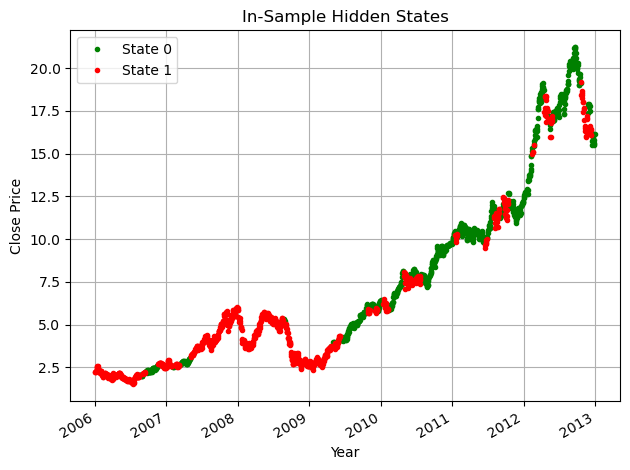

Plot for aapl


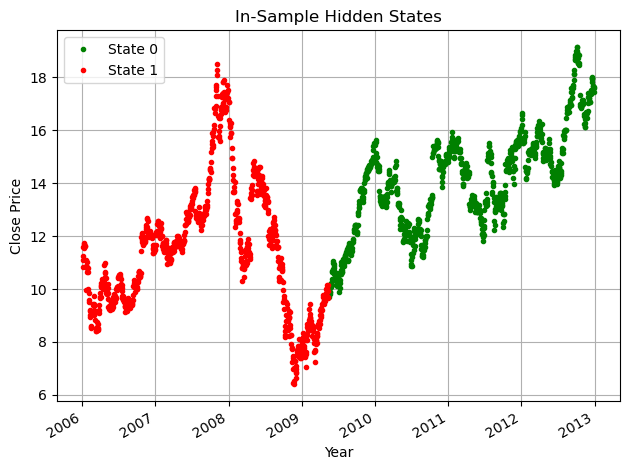

Plot for googl


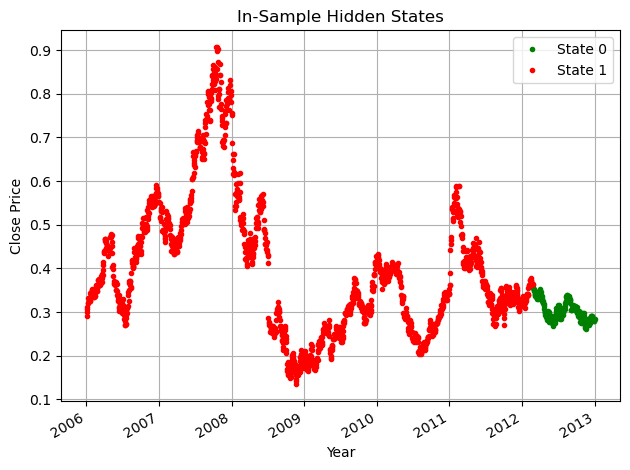

Plot for nvda


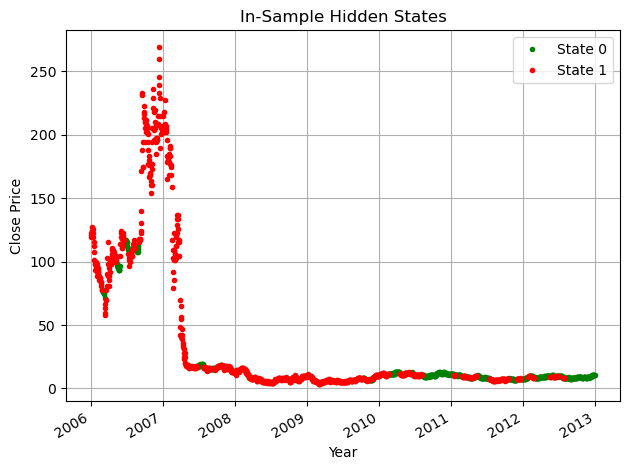

Plot for dal


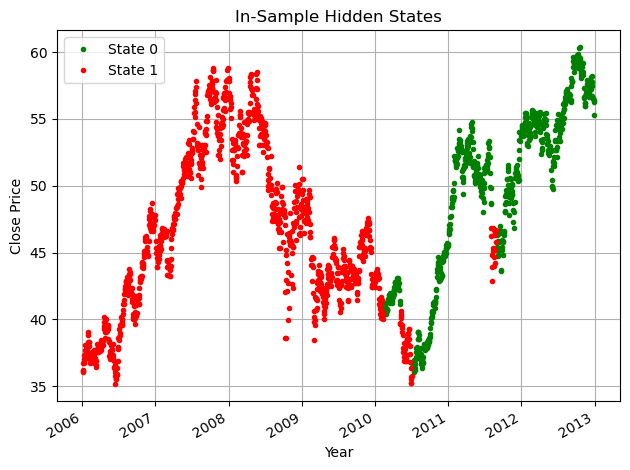

Plot for xom


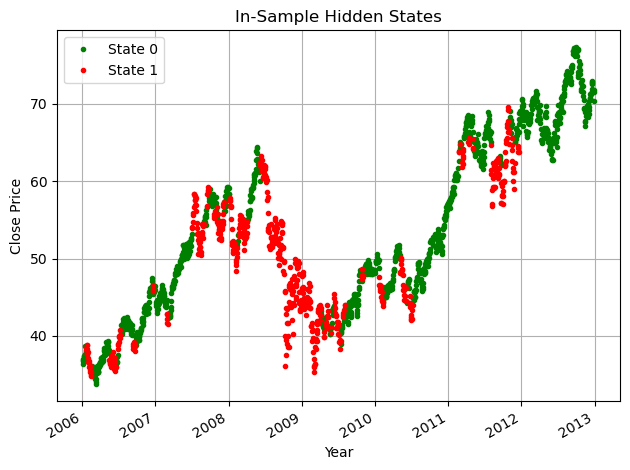

Plot for cvx


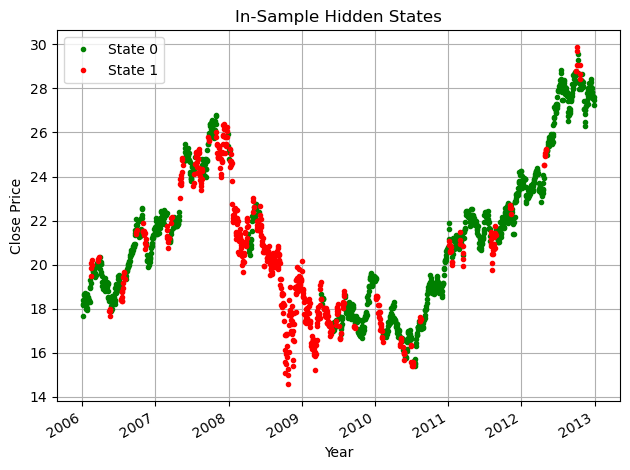

Plot for vz


In [61]:
for i in range(len(stocks)):
    stock = smooth_data_with_date[i]
    df= stock[stock["Date"].dt.year.isin(range(2006,2013))].reset_index(drop=True)
    df.set_index('Date', inplace=True)
    plot_in_sample_hidden_states(df)
    print(f"Plot for {stocks[i]}")

In [64]:
total=pd.concat(smooth_data_with_date).reset_index(drop=True)
total.to_csv('stock_hmm_output_kalman.csv')